In [2]:
import timedataparser as tdp
import tools
import matplotlib
import matplotlib.pyplot as plt
import pdfdefaults as pdf
import torch
from itertools import compress

date = '23-10-09'
folder = f'/home/dgotzens/localstorage/workspace/masterarbeit/recording/{date}/'
header = tdp.header(folder)
n_samples = header['SamplesPerRamp']
n_ramps = len(header['Chirps']) * len(header['Chirps'][0]['Ramps'])

data = tdp.timedata(folder, n_samples, n_ramps)
timestamps = tdp.timestamps(folder)
if data.shape[-1] < len(timestamps):
    timestamps = timestamps[:data.shape[-1]]
temperatures = tdp.temperatures(folder)
reboots = tdp.reboots(folder)

In [3]:
# nfft = 2**21
# m_refl = tools.reflidx(tools.rangedata(data[:,0,:], N=nfft))
# plt.plot(timestamps, (m_refl-m_refl[0])/nfft * 25000)
# plt.gca().xaxis.set_major_formatter(tools.hhmm)
# plt.xlabel(r'$t$')
# plt.ylabel(r'$\Delta d$ [mm]')
# plt.show()

In [4]:
x_pos = {int(ramp['RampId']) : int(ramp['X']) for chirp in header['Chirps'] for ramp in chirp['Ramps']}
y_pos = {int(ramp['RampId']) : int(ramp['Y']) for chirp in header['Chirps'] for ramp in chirp['Ramps']}

x_pos = [x_pos[k] for k in range(n_ramps)]
y_pos = [y_pos[k] for k in range(n_ramps)]

rx_id = {int(ramp['RampId']) : int(ramp['RxId']) for chirp in header['Chirps'] for ramp in chirp['Ramps']}
tx_id = {int(ramp['RampId']) : int(chirp['ChirpId']) for chirp in header['Chirps'] for ramp in chirp['Ramps']}

rx_id = [rx_id[k] for k in range(n_ramps)]
tx_id = [tx_id[k] for k in range(n_ramps)]

print(max(x_pos), max(y_pos))

85 6


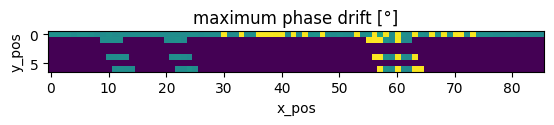

In [5]:
img = torch.full((max(x_pos)+1, max(y_pos)+1), -500)
for k in range(n_ramps):
    drift = tools.drift(tools.rangedata(data[:,k,:], N=2**12))
    max_phase_drift = tools.unwrap(drift.angle()).abs().max()
    img[x_pos[k], y_pos[k]] = max_phase_drift*180/torch.pi

plt.imshow(img.T)
plt.xlabel('x_pos')
plt.ylabel('y_pos')
plt.title('maximum phase drift [°]')
plt.show()

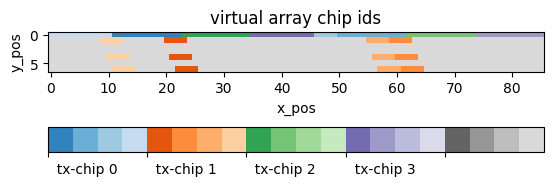

In [67]:
img = torch.full((max(x_pos)+1, max(y_pos)+1), 20)
for k in range(n_ramps):
   old = img[x_pos[k], y_pos[k]]
   new = 4*(tx_id[k]//3) + rx_id[k]//4
   if old>new:
      img[x_pos[k], y_pos[k]] = new

plt.imshow(img.T, cmap='tab20c')
plt.xlabel('x_pos')
plt.ylabel('y_pos')
clb = plt.colorbar(location='bottom')
clb.ax.set_xticks([0,4,8,12,16], [f'  tx-chip {k}' for k in range(4)]+[''])
for label in clb.ax.get_xticklabels():
    label.set_horizontalalignment('left')
plt.title('virtual array chip ids')
plt.show()

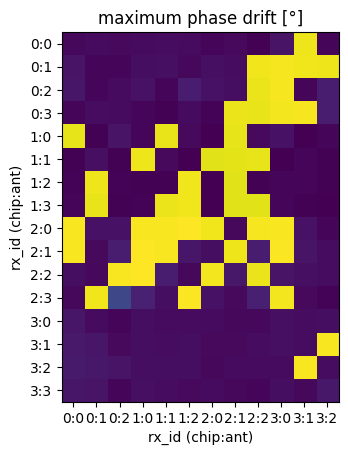

In [8]:
img = torch.zeros((max(rx_id)+1,max(tx_id)+1))
for k in range(n_ramps):
    drift = tools.drift(tools.rangedata(data[:,k,:], N=2**12))
    max_phase_drift = tools.unwrap(drift.angle()).abs().max()
    img[rx_id[k], tx_id[k]] = max_phase_drift*180/torch.pi

plt.imshow(img)
plt.xlabel('rx_id (chip:ant)')
plt.ylabel('rx_id (chip:ant)')
plt.xticks(range(12), [f'{k//3}:{k%3}' for k in range(12)])
plt.yticks(range(16), [f'{k//4}:{k%4}' for k in range(16)])
plt.title('maximum phase drift [°]')
plt.show()

In [1]:
std = lambda x : int(x) + 100/60*(x%1)
astd = lambda y : int(round(y*60)/60) + (round(y*60)%60)/100
stunden = lambda start,ende,mittagstart=0,mittagende=0 : astd(std(ende)-std(start)-(std(mittagende)-std(mittagstart)))

print(f'{stunden(9.15,16.55,11.55,13.00):.2f}h')

6.35h
